# Toto: Zero-Shot Blood Glucose Forecasting

This notebook demonstrates zero-shot forecasting using Toto (Time-Series-Optimized Transformer for Observability).

**Model**: Datadog/Toto-Open-Base-1.0 (151M parameters, trained on 2T data points)  
**Dataset**: Kaggle BrisT1D  
**Task**: 8-hour nocturnal blood glucose forecasting  

**Installation**: `pip install toto-ts`  
**Note**: Toto provides probabilistic forecasting with quantiles!

## Setup and Data Loading

In [13]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

from toto.model.toto import Toto
from toto.data.util.dataset import MaskedTimeseries
from toto.inference.forecaster import TotoForecaster

from src.data.diabetes_datasets.data_loader import get_loader
from src.data.models import ColumnNames
from src.utils.time_series_helper import get_interval_minutes

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"✅ Using torch {torch.__version__}")
print(f"✅ Using device: {device}")

✅ Using torch 2.7.0
✅ Using device: cpu


In [14]:
# Load Kaggle BrisT1D dataset
loader = get_loader(
    data_source_name="kaggle_brisT1D", 
    dataset_type="train", 
    use_cached=True
)

2025-12-06T12:36:39 - ============================================================
2025-12-06T12:36:39 - Beginning data loading process with the following parmeters:
2025-12-06T12:36:39 - 	Dataset: kaggle_brisT1D - train
2025-12-06T12:36:39 - 	Columns: None
2025-12-06T12:36:39 - 	Generic patient start date: 2024-01-01 00:00:00
2025-12-06T12:36:39 - 	Number of validation days: 20
2025-12-06T12:36:39 - 	In parallel with up to 3 workers.

2025-12-06T12:36:40 - Loaded full processed data from cache for 9 patients
2025-12-06T12:36:40 - Loaded existing train/validation split from cache for 9 patients


## Configuration

In [15]:
# Time series configuration (same as TEMPO/Chronos notebooks)
INTERVAL_MINS = 5
TRAIN_HOURS = 40  # Context length: 40 hours of history
PREDICTION_HOURS = 8  # Forecast: 8 hours ahead

prediction_length = int((PREDICTION_HOURS * 60) / INTERVAL_MINS)  # 96 timesteps
context_length = int(TRAIN_HOURS * 60 / INTERVAL_MINS)  # 480 timesteps

print(f"Context length: {context_length} timesteps ({TRAIN_HOURS} hours)")
print(f"Prediction length: {prediction_length} timesteps ({PREDICTION_HOURS} hours)")

# Target column
TARGET_COL = ColumnNames.BG.value
print(f"\nTarget: {TARGET_COL}")

Context length: 480 timesteps (40 hours)
Prediction length: 96 timesteps (8 hours)

Target: bg_mM


## Load Toto Model

In [16]:
# Load pretrained Toto model from HuggingFace
print("Loading Toto model from HuggingFace...")
toto = Toto.from_pretrained('Datadog/Toto-Open-Base-1.0')
toto.to(device)

# Create forecaster
forecaster = TotoForecaster(toto.model)
print("Toto model loaded successfully!")

Loading Toto model from HuggingFace...
Toto model loaded successfully!


## Zero-Shot Evaluation on Validation Set

In [17]:
# Get validation data from loader
if loader.validation_data is None:
    raise ValueError("No validation data found")

val_data: dict[str, pd.DataFrame] = loader.validation_data

# Evaluation metrics storage
all_predictions = []
all_targets = []
patient_metrics = []

print(f"Evaluating Toto on {len(val_data)} patients...\\n")

for patient_id, patient_df in val_data.items():
    # Skip if not 5-minute intervals
    if get_interval_minutes(patient_df) != INTERVAL_MINS:
        print(f"Skipping {patient_id}: interval not {INTERVAL_MINS} minutes")
        continue
    
    # Skip if not enough data
    if len(patient_df) < context_length + prediction_length:
        print(f"Skipping {patient_id}: insufficient data")
        continue
    
    print(f"Processing {patient_id}...")
    
    # Extract target column as numpy array
    target_data = patient_df[TARGET_COL].values
    timestamps = patient_df.index
    
    # Make predictions on sliding windows (limit to 5 for speed)
    patient_preds = []
    patient_targets = []
    
    num_windows = 0
    max_windows = 5
    
    for i in range(len(target_data) - context_length - prediction_length + 1):
        context = target_data[i:i+context_length]
        target = target_data[i+context_length:i+context_length+prediction_length]
        context_timestamps = timestamps[i:i+context_length]
        
        # IMPORTANT: Skip windows with NaN values
        # Unlike Chronos/TEMPO, Toto does NOT handle NaN internally!
        if np.isnan(context).any() or np.isnan(target).any():
            continue
        
        # Prepare Toto input
        series_tensor = torch.tensor(context, dtype=torch.float32).unsqueeze(0).to(device)
        padding_mask = torch.ones_like(series_tensor, dtype=torch.bool)
        id_mask = torch.zeros_like(series_tensor)
        timestamp_seconds = torch.tensor(
            [ts.timestamp() for ts in context_timestamps],
            dtype=torch.float32
        ).unsqueeze(0).to(device)
        time_interval = torch.tensor([INTERVAL_MINS * 60], dtype=torch.float32).to(device)
        
        inputs = MaskedTimeseries(
            series=series_tensor,
            padding_mask=padding_mask,
            id_mask=id_mask,
            timestamp_seconds=timestamp_seconds,
            time_interval_seconds=time_interval,
        )
        
        # Toto prediction (zero-shot)
        with torch.no_grad():
            forecast = forecaster.forecast(
                inputs,
                prediction_length=prediction_length,
                num_samples=100,  # Reduced for speed
                samples_per_batch=50,
            )
            pred = forecast.median.cpu().numpy().flatten()
        
        patient_preds.append(pred)
        patient_targets.append(target)
        
        num_windows += 1
        if num_windows >= max_windows:
            break
    
    if len(patient_preds) > 0:
        patient_preds = np.array(patient_preds)
        patient_targets = np.array(patient_targets)
        
        # Compute metrics
        mse = np.mean((patient_preds - patient_targets) ** 2)
        rmse = np.sqrt(mse)
        mae = np.mean(np.abs(patient_preds - patient_targets))
        
        patient_metrics.append({
            'patient_id': patient_id,
            'rmse': rmse,
            'mae': mae,
            'num_windows': len(patient_preds)
        })
        
        all_predictions.extend(patient_preds.flatten())
        all_targets.extend(patient_targets.flatten())
        
        print(f"  {patient_id}: RMSE={rmse:.3f}, MAE={mae:.3f} ({len(patient_preds)} windows)")

# Overall metrics
if len(all_predictions) > 0:
    all_predictions = np.array(all_predictions)
    all_targets = np.array(all_targets)
    
    overall_rmse = np.sqrt(np.mean((all_predictions - all_targets) ** 2))
    overall_mae = np.mean(np.abs(all_predictions - all_targets))
    overall_mape = np.mean(np.abs((all_predictions - all_targets) / (all_targets + 1e-8))) * 100
    
    print("\\n" + "="*60)
    print("Toto Zero-Shot Performance on Kaggle BrisT1D Validation Set")
    print("="*60)
    print(f"Overall RMSE: {overall_rmse:.3f} mmol/L")
    print(f"Overall MAE:  {overall_mae:.3f} mmol/L")
    print(f"Overall MAPE: {overall_mape:.2f}%")
    print(f"Total predictions: {len(all_predictions)}")
    print(f"Patients evaluated: {len(patient_metrics)}")
else:
    print("No predictions were made. Check data compatibility.")

Evaluating Toto on 9 patients...\n
Skipping p01: interval not 5 minutes
Processing p03...
  p03: RMSE=5.246, MAE=3.885 (5 windows)
Processing p02...
  p02: RMSE=3.763, MAE=3.256 (5 windows)
Processing p04...
  p04: RMSE=2.793, MAE=2.308 (5 windows)
Skipping p05: interval not 5 minutes
Skipping p06: interval not 5 minutes
Processing p11...
  p11: RMSE=3.311, MAE=3.101 (5 windows)
Processing p12...
  p12: RMSE=1.865, MAE=1.490 (5 windows)
Processing p10...
  p10: RMSE=2.655, MAE=1.628 (5 windows)
\n============================================================
Toto Zero-Shot Performance on Kaggle BrisT1D Validation Set
Overall RMSE: 3.439 mmol/L
Overall MAE:  2.611 mmol/L
Overall MAPE: 39.36%
Total predictions: 2880
Patients evaluated: 6


## Per-Patient Results

In [18]:
# Display per-patient metrics
if len(patient_metrics) > 0:
    metrics_df = pd.DataFrame(patient_metrics)
    print("\nPer-Patient Metrics:")
    print(metrics_df.to_string(index=False))
    print(f"\nAverage RMSE across patients: {metrics_df['rmse'].mean():.3f} mmol/L")
    print(f"Average MAE across patients:  {metrics_df['mae'].mean():.3f} mmol/L")


Per-Patient Metrics:
patient_id     rmse      mae  num_windows
       p03 5.245627 3.885283            5
       p02 3.762907 3.256022            5
       p04 2.793052 2.308113            5
       p11 3.310783 3.100618            5
       p12 1.865213 1.490363            5
       p10 2.654746 1.628199            5

Average RMSE across patients: 3.272 mmol/L
Average MAE across patients:  2.611 mmol/L


## Visualization: Sample Predictions

Visualizing predictions for p02...


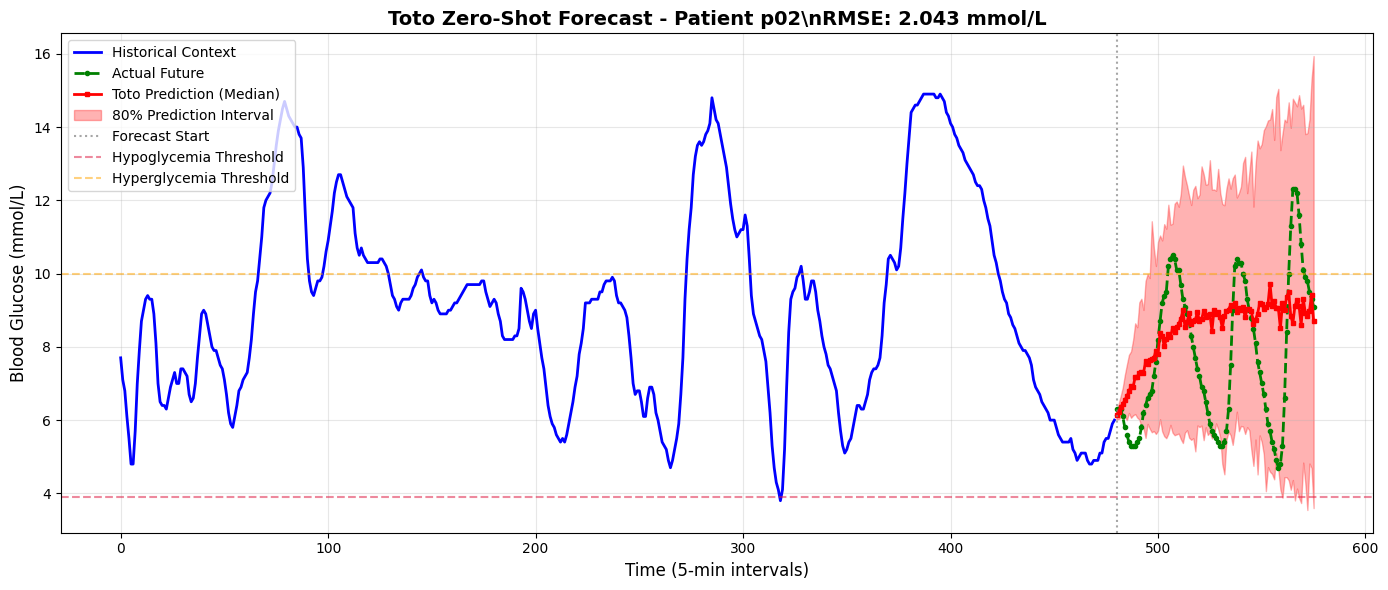

In [ ]:
# Visualize predictions for one patient
if len(val_data) > 0:
    # Pick first valid patient
    sample_patient_id = "p02"
    
    if sample_patient_id:
        print(f"Visualizing predictions for {sample_patient_id}...")
        
        patient_df = val_data[sample_patient_id]
        target_data = patient_df[TARGET_COL].values
        timestamps = patient_df.index
        
        # Take one window from the middle of the data
        mid_idx = len(target_data) // 2
        start_idx = max(0, mid_idx - context_length)
        
        context = target_data[start_idx:start_idx+context_length]
        actual_future = target_data[start_idx+context_length:start_idx+context_length+prediction_length]
        context_timestamps = timestamps[start_idx:start_idx+context_length]
        
        # Skip if NaN values present
        if np.isnan(context).any() or np.isnan(actual_future).any():
            print("Warning: Selected window contains NaN values. Skipping visualization.")
            print("Try selecting a different patient or time window.")
        else:
            # Prepare Toto input
            series_tensor = torch.tensor(context, dtype=torch.float32).unsqueeze(0).to(device)
            padding_mask = torch.ones_like(series_tensor, dtype=torch.bool)
            id_mask = torch.zeros_like(series_tensor)
            timestamp_seconds = torch.tensor(
                [ts.timestamp() for ts in context_timestamps],
                dtype=torch.float32
            ).unsqueeze(0).to(device)
            time_interval = torch.tensor([INTERVAL_MINS * 60], dtype=torch.float32).to(device)
            
            inputs = MaskedTimeseries(
                series=series_tensor,
                padding_mask=padding_mask,
                id_mask=id_mask,
                timestamp_seconds=timestamp_seconds,
                time_interval_seconds=time_interval,
            )
            
            # Make prediction with quantiles
            with torch.no_grad():
                forecast = forecaster.forecast(
                    inputs,
                    prediction_length=prediction_length,
                    num_samples=256,
                    samples_per_batch=64,
                )
                predicted_future = forecast.median.cpu().numpy().flatten()
                q10 = forecast.quantile(0.1).cpu().numpy().flatten()
                q90 = forecast.quantile(0.9).cpu().numpy().flatten()
            
            # Plot
            fig, ax = plt.subplots(figsize=(14, 6))
            
            time_context = np.arange(len(context))
            time_future = np.arange(len(context), len(context) + len(actual_future))
            
            ax.plot(time_context, context, label='Historical Context', color='blue', linewidth=2)
            ax.plot(time_future, actual_future, label='Actual Future', color='green', linestyle='--', linewidth=2, marker='o', markersize=3)
            ax.plot(time_future, predicted_future, label='Toto Prediction (Median)', color='red', linewidth=2, marker='s', markersize=3)
            ax.fill_between(time_future, q10, q90, alpha=0.3, color='red', label='80% Prediction Interval')
            
            ax.axvline(x=len(context), color='gray', linestyle=':', linewidth=1.5, alpha=0.7, label='Forecast Start')
            ax.axhline(y=3.9, color='crimson', linestyle='--', alpha=0.5, label='Hypoglycemia Threshold')
            ax.axhline(y=10.0, color='orange', linestyle='--', alpha=0.5, label='Hyperglycemia Threshold')
            
            rmse_window = np.sqrt(np.mean((predicted_future - actual_future) ** 2))
            
            ax.set_xlabel('Time (5-min intervals)', fontsize=12)
            ax.set_ylabel('Blood Glucose (mmol/L)', fontsize=12)
            ax.set_title(f'Toto Zero-Shot Forecast - Patient {sample_patient_id}\\nRMSE: {rmse_window:.3f} mmol/L', fontsize=14, fontweight='bold')
            ax.legend(loc='best', fontsize=10)
            ax.grid(True, alpha=0.3)
            
            plt.tight_layout()
            plt.show()
    else:
        print("No suitable patient found for visualization.")

## Comparison with Baselines

To compare Toto with other models (Chronos, TEMPO, TTM), run those notebooks and compare metrics:

- Chronos notebook: `4.11-tc-amazon-chronos_forecasting.ipynb`
- TEMPO notebook: `4.12-ad-tempo-forecasting.ipynb`
- TTM zero-shot: `4.08-ad-cr-ttm-forecast-zs.ipynb`

Key metrics to compare:
- RMSE (lower is better)
- MAE (lower is better)
- Inference speed
- Probabilistic calibration (for Toto)

## Notes and Observations

**Toto Characteristics:**
- 151M parameter foundation model
- Zero-shot capable (no training required)
- Trained on 2 trillion observability metrics (not healthcare-specific)
- **Probabilistic forecasting** with quantiles (80% prediction intervals)
- Decoder-only transformer architecture

**Implementation Notes:**
- Uses data directly from loader
- Simple, clean implementation following TEMPO/Chronos notebook pattern
- Provides uncertainty estimates via quantiles
- **IMPORTANT**: Unlike Chronos/TEMPO, Toto does NOT handle NaN values internally
  - Must skip or impute NaN values before feeding to model
  - NaN values cause numerical instability in the Student-T distribution
  - Current implementation skips windows containing NaN

**Potential Improvements:**
1. Incorporate exogenous features (COB, IOB) - Toto supports multivariate
2. Fine-tune on diabetes-specific data
3. Experiment with different context lengths
4. Leverage probabilistic predictions for risk assessment
5. Compare with healthcare-focused models (UniTS)
6. Implement proper NaN imputation instead of skipping windows

**Next Steps:**
- Compare with UniTS (healthcare pre-trained)
- Compare with TEMPO and Chronos
- Implement PatchTST for comparison
- Consider ensemble methods

---

# Multivariate Forecasting with Exogenous Features

Now let's test Toto with **multivariate input** by incorporating exogenous features:
- Insulin on board (IOB)
- Carbs on board (COB) 
- Insulin doses
- Carb intake
- Activity metrics (HR, steps, calories)

This should improve accuracy since Toto can leverage the relationship between glucose, insulin, and nutrition.

## Multivariate Configuration

In [20]:
# Select exogenous features to include (matching TTM notebook approach)
# Note: HR excluded due to too many NaNs (as noted in TTM notebook)
EXOG_FEATURES = [
    ColumnNames.IOB.value,              # Insulin on board (derived, continuous)
    ColumnNames.COB.value,              # Carbs on board (derived, continuous)
    ColumnNames.STEPS.value,            # Step count (impute with 0)
    ColumnNames.CALS.value,             # Calories burned (impute with min value)
]

# All features: target + exogenous
ALL_FEATURES = [TARGET_COL] + EXOG_FEATURES

print(f"Multivariate Toto Configuration:")
print(f"  Target: {TARGET_COL}")
print(f"  Exogenous features ({len(EXOG_FEATURES)}):")
for feat in EXOG_FEATURES:
    print(f"    - {feat}")
print(f"\n  Total channels: {len(ALL_FEATURES)}")
print(f"\n  Note: HR excluded (too many NaNs), dose_units/food_g replaced by IOB/COB")

Multivariate Toto Configuration:
  Target: bg_mM
  Exogenous features (4):
    - iob
    - cob
    - steps
    - cals

  Total channels: 5

  Note: HR excluded (too many NaNs), dose_units/food_g replaced by IOB/COB


## Multivariate Zero-Shot Evaluation

In [21]:
# Evaluation metrics storage
all_predictions_mv = []
all_targets_mv = []
patient_metrics_mv = []

print(f"Evaluating Multivariate Toto on {len(val_data)} patients...")
print(f"Imputation strategy (matching TTM notebooks):")
print(f"  - IOB/COB: forward-fill → backward-fill (continuous derived features)")
print(f"  - Steps: constant = 0")
print(f"  - Cals: constant = min value\n")

for patient_id, patient_df in val_data.items():
    # Skip if not 5-minute intervals
    if get_interval_minutes(patient_df) != INTERVAL_MINS:
        print(f"Skipping {patient_id}: interval not {INTERVAL_MINS} minutes")
        continue
    
    # Skip if not enough data
    if len(patient_df) < context_length + prediction_length:
        print(f"Skipping {patient_id}: insufficient data")
        continue
    
    # Check if all required features exist
    missing_features = [f for f in ALL_FEATURES if f not in patient_df.columns]
    if missing_features:
        print(f"Skipping {patient_id}: missing features {missing_features}")
        continue
    
    print(f"Processing {patient_id}...")
    
    # Extract all features and apply proper imputation
    feature_df = patient_df[ALL_FEATURES].copy()
    
    # Imputation strategy matching TTM notebook approach:
    # 1. IOB/COB: forward-fill then backward-fill (continuous derived features)
    for col in [ColumnNames.IOB.value, ColumnNames.COB.value]:
        if col in feature_df.columns:
            feature_df[col] = feature_df[col].ffill().bfill()
    
    # 2. Steps: constant = 0 (no activity = 0 steps)
    if ColumnNames.STEPS.value in feature_df.columns:
        feature_df[ColumnNames.STEPS.value] = feature_df[ColumnNames.STEPS.value].fillna(0)
    
    # 3. Cals: constant = min value (baseline metabolic rate)
    if ColumnNames.CALS.value in feature_df.columns:
        min_cals = feature_df[ColumnNames.CALS.value].min()
        if pd.isna(min_cals):
            min_cals = 0  # Fallback if all NaN
        feature_df[ColumnNames.CALS.value] = feature_df[ColumnNames.CALS.value].fillna(min_cals)
    
    # 4. BG target: don't impute, we'll skip windows with NaN targets
    # (leave TARGET_COL as-is in feature_df for context, but check original for target)
    feature_df[TARGET_COL] = feature_df[TARGET_COL].ffill().bfill()
    
    feature_data = feature_df.values  # (timesteps, features)
    timestamps = patient_df.index
    
    # Get original BG for target evaluation (don't use imputed target)
    target_data_original = patient_df[TARGET_COL].values
    
    # Make predictions on sliding windows (limit to 5 for speed)
    patient_preds = []
    patient_targets = []
    
    num_windows = 0
    max_windows = 5
    
    for i in range(len(feature_data) - context_length - prediction_length + 1):
        # Extract context window for all features (imputed)
        context_multivar = feature_data[i:i+context_length]  # (480, 5)
        
        # Target is original blood glucose - skip if NaN
        target_bg = target_data_original[i+context_length:i+context_length+prediction_length]
        
        context_timestamps = timestamps[i:i+context_length]
        
        # Only skip if TARGET has NaN (context features are imputed)
        if np.isnan(target_bg).any():
            continue
        
        # Also check context doesn't have NaN after imputation
        if np.isnan(context_multivar).any():
            continue
        
        # Prepare Toto multivariate input
        # Transpose to (features, timesteps) format
        series_tensor = torch.tensor(
            context_multivar.T,  # Transpose: (480, 5) → (5, 480)
            dtype=torch.float32
        ).to(device)  # Shape: (5, 480)
        
        # Create masks for all channels
        padding_mask = torch.ones_like(series_tensor, dtype=torch.bool)
        id_mask = torch.zeros_like(series_tensor)
        
        # Timestamp for each channel (broadcast to match)
        timestamp_seconds = torch.tensor(
            [ts.timestamp() for ts in context_timestamps],
            dtype=torch.float32
        ).unsqueeze(0).expand(len(ALL_FEATURES), -1).to(device)  # (5, 480)
        
        # Time interval for each channel
        time_interval = torch.full(
            (len(ALL_FEATURES),),
            INTERVAL_MINS * 60,
            dtype=torch.float32
        ).to(device)  # (5,)
        
        inputs = MaskedTimeseries(
            series=series_tensor,
            padding_mask=padding_mask,
            id_mask=id_mask,
            timestamp_seconds=timestamp_seconds,
            time_interval_seconds=time_interval,
        )
        
        # Toto multivariate prediction (zero-shot)
        try:
            with torch.no_grad():
                forecast = forecaster.forecast(
                    inputs,
                    prediction_length=prediction_length,
                    num_samples=100,
                    samples_per_batch=50,
                )
                # Prediction is for first channel (blood glucose)
                # forecast.median shape: (batch, channels, time) = (1, 5, 96)
                median_np = forecast.median.cpu().numpy()
                if len(median_np.shape) == 3:
                    pred = median_np[0, 0]  # (batch=0, channel=0) → (96,)
                elif len(median_np.shape) == 2:
                    pred = median_np[0]  # (channel=0) → (96,)
                else:
                    pred = median_np.flatten()[:prediction_length]
            
            patient_preds.append(pred)
            patient_targets.append(target_bg)
            
            num_windows += 1
            if num_windows >= max_windows:
                break
        except Exception as e:
            print(f"  Error in window {i}: {e}")
            continue
    
    if len(patient_preds) > 0:
        patient_preds = np.array(patient_preds)
        patient_targets = np.array(patient_targets)
        
        # Compute metrics
        mse = np.mean((patient_preds - patient_targets) ** 2)
        rmse = np.sqrt(mse)
        mae = np.mean(np.abs(patient_preds - patient_targets))
        
        patient_metrics_mv.append({
            'patient_id': patient_id,
            'rmse': rmse,
            'mae': mae,
            'num_windows': len(patient_preds)
        })
        
        all_predictions_mv.extend(patient_preds.flatten())
        all_targets_mv.extend(patient_targets.flatten())
        
        print(f"  {patient_id}: RMSE={rmse:.3f}, MAE={mae:.3f} ({len(patient_preds)} windows)")
    else:
        print(f"  {patient_id}: No valid windows (target BG has too many NaN)")

# Overall metrics
if len(all_predictions_mv) > 0:
    all_predictions_mv = np.array(all_predictions_mv)
    all_targets_mv = np.array(all_targets_mv)
    
    overall_rmse_mv = np.sqrt(np.mean((all_predictions_mv - all_targets_mv) ** 2))
    overall_mae_mv = np.mean(np.abs(all_predictions_mv - all_targets_mv))
    overall_mape_mv = np.mean(np.abs((all_predictions_mv - all_targets_mv) / (all_targets_mv + 1e-8))) * 100
    
    print("\n" + "="*60)
    print("Multivariate Toto Zero-Shot Performance")
    print("="*60)
    print(f"Overall RMSE: {overall_rmse_mv:.3f} mmol/L")
    print(f"Overall MAE:  {overall_mae_mv:.3f} mmol/L")
    print(f"Overall MAPE: {overall_mape_mv:.2f}%")
    print(f"Total predictions: {len(all_predictions_mv)}")
    print(f"Patients evaluated: {len(patient_metrics_mv)}")
else:
    print("No predictions were made. Check data compatibility.")

Evaluating Multivariate Toto on 9 patients...
Imputation strategy (matching TTM notebooks):
  - IOB/COB: forward-fill → backward-fill (continuous derived features)
  - Steps: constant = 0
  - Cals: constant = min value

Skipping p01: interval not 5 minutes
Processing p03...
  p03: RMSE=3.947, MAE=3.028 (5 windows)
Processing p02...
  p02: RMSE=3.291, MAE=2.545 (5 windows)
Processing p04...
  p04: RMSE=2.746, MAE=2.387 (5 windows)
Skipping p05: interval not 5 minutes
Skipping p06: interval not 5 minutes
Processing p11...
  p11: RMSE=2.711, MAE=2.515 (5 windows)
Processing p12...
  p12: RMSE=1.857, MAE=1.485 (5 windows)
Processing p10...
  p10: RMSE=0.436, MAE=0.352 (5 windows)

Multivariate Toto Zero-Shot Performance
Overall RMSE: 2.737 mmol/L
Overall MAE:  2.052 mmol/L
Overall MAPE: 31.43%
Total predictions: 2880
Patients evaluated: 6


## Comparison: Univariate vs Multivariate

In [24]:
# Compare univariate vs multivariate results
if len(patient_metrics) > 0 and len(patient_metrics_mv) > 0:
    print("="*70)
    print("UNIVARIATE vs MULTIVARIATE TOTO COMPARISON")
    print("="*70)
    print()
    
    # Overall comparison
    print("Overall Metrics:")
    print(f"  Univariate  RMSE: {overall_rmse:.3f} mmol/L")
    print(f"  Multivariate RMSE: {overall_rmse_mv:.3f} mmol/L")
    improvement_rmse = ((overall_rmse - overall_rmse_mv) / overall_rmse) * 100
    print(f"  → Improvement: {improvement_rmse:+.1f}%")
    print()
    print(f"  Univariate  MAE:  {overall_mae:.3f} mmol/L")
    print(f"  Multivariate MAE:  {overall_mae_mv:.3f} mmol/L")
    improvement_mae = ((overall_mae - overall_mae_mv) / overall_mae) * 100
    print(f"  → Improvement: {improvement_mae:+.1f}%")
    print()
    
    # Per-patient comparison
    print("Per-Patient Comparison:")
    print(f"{'Patient':<10} {'Uni RMSE':<12} {'Multi RMSE':<12} {'Improvement':<12}")
    print("-" * 50)
    
    # Match patients between univariate and multivariate
    uni_dict = {m['patient_id']: m for m in patient_metrics}
    mv_dict = {m['patient_id']: m for m in patient_metrics_mv}
    
    common_patients = set(uni_dict.keys()) & set(mv_dict.keys())
    
    for pid in sorted(common_patients):
        uni_rmse = uni_dict[pid]['rmse']
        mv_rmse = mv_dict[pid]['rmse']
        improvement = ((uni_rmse - mv_rmse) / uni_rmse) * 100
        
        print(f"{pid:<10} {uni_rmse:<12.3f} {mv_rmse:<12.3f} {improvement:+.1f}%")
    
    print()
    print(f"Patients evaluated in both: {len(common_patients)}")
    
    # Summary statistics
    if len(common_patients) > 0:
        avg_improvement = np.mean([
            ((uni_dict[pid]['rmse'] - mv_dict[pid]['rmse']) / uni_dict[pid]['rmse']) * 100
            for pid in common_patients
        ])
        print(f"Average RMSE improvement: {avg_improvement:+.1f}%")
else:
    print("Run both univariate and multivariate evaluations first to compare results.")

UNIVARIATE vs MULTIVARIATE TOTO COMPARISON

Overall Metrics:
  Univariate  RMSE: 3.439 mmol/L
  Multivariate RMSE: 2.737 mmol/L
  → Improvement: +20.4%

  Univariate  MAE:  2.611 mmol/L
  Multivariate MAE:  2.052 mmol/L
  → Improvement: +21.4%

Per-Patient Comparison:
Patient    Uni RMSE     Multi RMSE   Improvement 
--------------------------------------------------
p02        3.763        3.291        +12.5%
p03        5.246        3.947        +24.8%
p04        2.793        2.746        +1.7%
p10        2.655        0.436        +83.6%
p11        3.311        2.711        +18.1%
p12        1.865        1.857        +0.4%

Patients evaluated in both: 6
Average RMSE improvement: +23.5%


## Visual Comparison: Univariate vs Multivariate

Comparing predictions for p02...


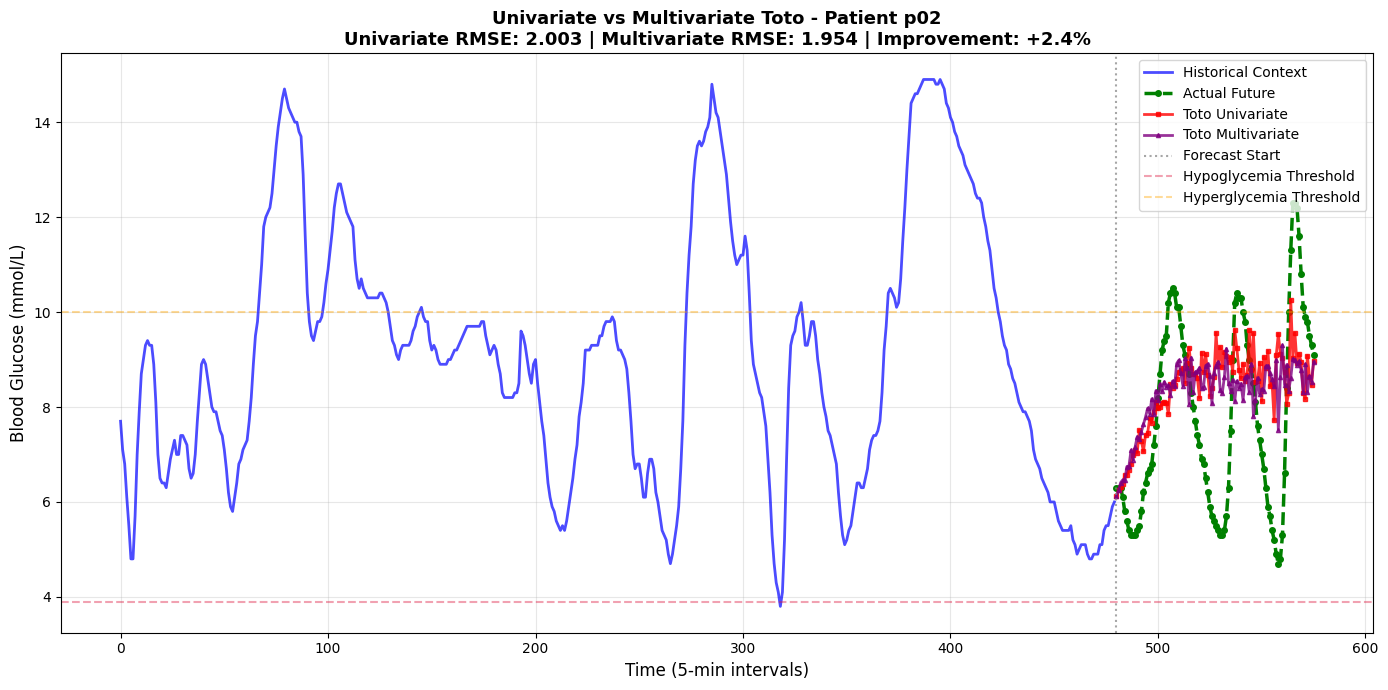

In [ ]:
# Visualize univariate vs multivariate predictions on same patient
if len(val_data) > 0:
    # Pick first valid patient with all features
    sample_patient_id = "p02"
    
    if sample_patient_id:
        print(f"Comparing predictions for {sample_patient_id}...")
        
        patient_df = val_data[sample_patient_id]
        
        # Take one window from the middle
        target_data = patient_df[TARGET_COL].values
        timestamps = patient_df.index
        
        # Apply proper imputation (matching TTM approach)
        feature_df = patient_df[ALL_FEATURES].copy()
        
        # IOB/COB: forward-fill then backward-fill
        for col in [ColumnNames.IOB.value, ColumnNames.COB.value]:
            if col in feature_df.columns:
                feature_df[col] = feature_df[col].ffill().bfill()
        
        # Steps: constant = 0
        if ColumnNames.STEPS.value in feature_df.columns:
            feature_df[ColumnNames.STEPS.value] = feature_df[ColumnNames.STEPS.value].fillna(0)
        
        # Cals: constant = min value
        if ColumnNames.CALS.value in feature_df.columns:
            min_cals = feature_df[ColumnNames.CALS.value].min()
            if pd.isna(min_cals):
                min_cals = 0
            feature_df[ColumnNames.CALS.value] = feature_df[ColumnNames.CALS.value].fillna(min_cals)
        
        # BG: forward-fill for context
        feature_df[TARGET_COL] = feature_df[TARGET_COL].ffill().bfill()
        
        feature_data = feature_df.values
        
        mid_idx = len(target_data) // 2
        start_idx = max(0, mid_idx - context_length)
        
        context_bg = target_data[start_idx:start_idx+context_length]
        actual_future = target_data[start_idx+context_length:start_idx+context_length+prediction_length]
        context_multivar = feature_data[start_idx:start_idx+context_length]
        context_timestamps = timestamps[start_idx:start_idx+context_length]
        
        # Check if BG target has NaN
        if np.isnan(context_bg).any() or np.isnan(actual_future).any():
            print("Warning: Selected window contains NaN in blood glucose.")
        elif np.isnan(context_multivar).any():
            print("Warning: Context still has NaN after imputation.")
        else:
            # Univariate prediction
            series_tensor_uni = torch.tensor(context_bg, dtype=torch.float32).unsqueeze(0).to(device)
            padding_mask_uni = torch.ones_like(series_tensor_uni, dtype=torch.bool)
            id_mask_uni = torch.zeros_like(series_tensor_uni)
            timestamp_seconds_uni = torch.tensor(
                [ts.timestamp() for ts in context_timestamps],
                dtype=torch.float32
            ).unsqueeze(0).to(device)
            time_interval_uni = torch.tensor([INTERVAL_MINS * 60], dtype=torch.float32).to(device)
            
            inputs_uni = MaskedTimeseries(
                series=series_tensor_uni,
                padding_mask=padding_mask_uni,
                id_mask=id_mask_uni,
                timestamp_seconds=timestamp_seconds_uni,
                time_interval_seconds=time_interval_uni,
            )
            
            # Multivariate prediction
            series_tensor_mv = torch.tensor(context_multivar.T, dtype=torch.float32).to(device)
            padding_mask_mv = torch.ones_like(series_tensor_mv, dtype=torch.bool)
            id_mask_mv = torch.zeros_like(series_tensor_mv)
            timestamp_seconds_mv = torch.tensor(
                [ts.timestamp() for ts in context_timestamps],
                dtype=torch.float32
            ).unsqueeze(0).expand(len(ALL_FEATURES), -1).to(device)
            time_interval_mv = torch.full(
                (len(ALL_FEATURES),),
                INTERVAL_MINS * 60,
                dtype=torch.float32
            ).to(device)
            
            inputs_mv = MaskedTimeseries(
                series=series_tensor_mv,
                padding_mask=padding_mask_mv,
                id_mask=id_mask_mv,
                timestamp_seconds=timestamp_seconds_mv,
                time_interval_seconds=time_interval_mv,
            )
            
            # Generate both predictions
            with torch.no_grad():
                forecast_uni = forecaster.forecast(inputs_uni, prediction_length=prediction_length, num_samples=100, samples_per_batch=50)
                pred_uni = forecast_uni.median.cpu().numpy().flatten()
                
                forecast_mv = forecaster.forecast(inputs_mv, prediction_length=prediction_length, num_samples=100, samples_per_batch=50)
                # Multivariate output: (batch, channels, time) = (1, 5, 96)
                median_mv = forecast_mv.median.cpu().numpy()
                if len(median_mv.shape) == 3:
                    pred_mv = median_mv[0, 0]
                elif len(median_mv.shape) == 2:
                    pred_mv = median_mv[0]
                else:
                    pred_mv = median_mv.flatten()[:prediction_length]
            
            # Plot comparison
            fig, ax = plt.subplots(figsize=(14, 7))
            
            time_context = np.arange(len(context_bg))
            time_future = np.arange(len(context_bg), len(context_bg) + len(actual_future))
            
            # Plot context and actual
            ax.plot(time_context, context_bg, label='Historical Context', color='blue', linewidth=2, alpha=0.7)
            ax.plot(time_future, actual_future, label='Actual Future', color='green', linestyle='--', linewidth=2.5, marker='o', markersize=4)
            
            # Plot both predictions
            ax.plot(time_future, pred_uni, label='Toto Univariate', color='red', linewidth=2, marker='s', markersize=3, alpha=0.8)
            ax.plot(time_future, pred_mv, label='Toto Multivariate', color='purple', linewidth=2, marker='^', markersize=3, alpha=0.8)
            
            ax.axvline(x=len(context_bg), color='gray', linestyle=':', linewidth=1.5, alpha=0.7, label='Forecast Start')
            ax.axhline(y=3.9, color='crimson', linestyle='--', alpha=0.4, label='Hypoglycemia Threshold')
            ax.axhline(y=10.0, color='orange', linestyle='--', alpha=0.4, label='Hyperglycemia Threshold')
            
            # Calculate RMSEs
            rmse_uni = np.sqrt(np.mean((pred_uni - actual_future) ** 2))
            rmse_mv = np.sqrt(np.mean((pred_mv - actual_future) ** 2))
            improvement = ((rmse_uni - rmse_mv) / rmse_uni) * 100
            
            ax.set_xlabel('Time (5-min intervals)', fontsize=12)
            ax.set_ylabel('Blood Glucose (mmol/L)', fontsize=12)
            ax.set_title(
                f'Univariate vs Multivariate Toto - Patient {sample_patient_id}\n' +
                f'Univariate RMSE: {rmse_uni:.3f} | Multivariate RMSE: {rmse_mv:.3f} | Improvement: {improvement:+.1f}%',
                fontsize=13,
                fontweight='bold'
            )
            ax.legend(loc='best', fontsize=10)
            ax.grid(True, alpha=0.3)
            
            plt.tight_layout()
            plt.show()
    else:
        print("No suitable patient found with all required features.")